In [531]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [532]:
q = '''select advisory_id, package_id, ecosystem, type, severity, disclose_date, publish_date,
       fix_commit_date, release_date, version
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where ecosystem = 'npm'
        and commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where ecosystem = 'npm'
        and type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id;'''
df = pd.DataFrame(sql.execute(q))
df['fix_to_release_delay'] = (df['release_date'].dt.date - df['fix_commit_date'].dt.date).dt.days
df['disclose_to_fix_delay'] = (df['fix_commit_date'].dt.date - df['disclose_date']).dt.days
df['release_to_publish_delay'] = (df['publish_date'] - df['release_date'].dt.date).dt.days
df['fix_to_publish_delay'] = (df['publish_date'] - df['fix_commit_date'].dt.date).dt.days
df

,advisory_id,package_id,ecosystem,type,severity,disclose_date,publish_date,fix_commit_date,release_date,version,fix_to_release_delay,disclose_to_fix_delay,release_to_publish_delay,fix_to_publish_delay
0,SNYK-JS-MONGODBCLIENTENCRYPTION-1079243,8,npm,Man-in-the-Middle (MitM),M,2021-02-26,2021-02-26,2021-02-05 23:37:36,2021-02-05 23:40:54,1.2.1,0,-21,21,21
1,npm:nunjucks:20160906,20,npm,Cross-site Scripting (XSS),H,2016-09-06,2016-09-09,2016-09-07 04:46:51,2016-09-07 16:39:10,2.4.3,0,1,2,2
2,SNYK-JS-NUNJUCKS-1079083,20,npm,Prototype Pollution,H,2021-02-25,2021-02-25,2020-11-25 03:46:10,2021-02-15 19:38:37,3.2.3,82,-92,10,92
3,SNYK-JS-URLPARSE-1078283,26,npm,Improper Input Validation,M,2021-02-22,2021-02-22,2021-02-17 14:34:13,2021-02-17 15:18:57,1.5.0,0,-5,5,5
4,SNYK-JS-RENDERTRON-1078501,28,npm,Server-side Request Forgery (SSRF),M,2021-02-23,2021-02-23,2020-06-04 10:39:17,2020-07-02 15:40:07,3.0.0,28,-264,236,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,SNYK-JS-DOTTY-1069933,3919,npm,Prototype Pollution,H,2021-02-03,2021-02-03,2021-01-25 18:20:41,2021-01-25 19:03:28,0.1.1,0,-9,9,9
662,SNYK-JS-GITLOG-1070779,3927,npm,Command Injection,H,2021-02-09,2021-02-09,2020-12-17 11:48:28,2021-01-05 21:20:58,4.0.4,19,-54,35,54
663,SNYK-JS-GETIPRANGE-1073612,3931,npm,Denial of Service (DoS),H,2021-02-12,2021-02-12,2021-02-10 22:48:28,2021-02-10 23:10:12,4.0.0,0,-2,2,2
664,SNYK-JS-PROGFAYSCRAPBOXPARSER-1076803,3934,npm,Regular Expression Denial of Service (ReDoS),H,2021-02-19,2021-02-19,2021-02-07 09:37:40,2021-02-18 16:06:23,6.0.3,11,-12,1,12


In [533]:
df['disclose_to_fix_delay'].describe()

count     666.000000
mean       -1.642643
std       124.741784
min     -1127.000000
25%        -6.000000
50%         0.000000
75%         3.000000
max      1028.000000
Name: disclose_to_fix_delay, dtype: float64

In [534]:
print(len(df))
d2f = df[df['disclose_to_fix_delay'] > 0]
print(len(d2f))
d2f['disclose_to_fix_delay'].describe()


666
260


count     260.000000
mean       56.792308
std       122.293191
min         1.000000
25%         1.750000
50%         8.500000
75%        41.250000
max      1028.000000
Name: disclose_to_fix_delay, dtype: float64

In [535]:
df['release_to_publish_delay'].describe()

count     666.000000
mean      126.174174
std       340.162468
min      -545.000000
25%         0.000000
50%         5.000000
75%        57.000000
max      2020.000000
Name: release_to_publish_delay, dtype: float64

In [536]:
wrong = df[df['fix_to_release_delay'] < 0]
wrong.to_csv('delaylessthanzero.csv', index=False)

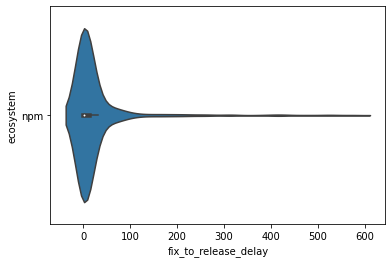

In [537]:
df= df[df['fix_to_release_delay'] >= 0]
ax = sns.violinplot(x='fix_to_release_delay', y='ecosystem', data = df)
plt.savefig('fix_to_release_delay.png')

In [538]:
gb = df.groupby('ecosystem')
eco_dfs = [(x,gb.get_group(x)) for x in gb.groups]
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')[['advisory_id']].count()
fixrel = df.groupby('ecosystem')[['fix_to_release_delay']].median()
pub_before_release = df[df['release_to_publish_delay']<0]
pub_before_release = pub_before_release.groupby('ecosystem')[['advisory_id']].count()
pub_before_fix = df[df['fix_to_publish_delay']<0]
pub_before_fix = pub_before_fix.groupby('ecosystem')[['advisory_id']].count()


In [539]:
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel, fixrel,pub_before_release, pub_before_fix])
final = final.reset_index()
final.columns = ['ecosystem','advisory','package','releases','fix_to_release', 'publish_before_release','publish_before_fix']
final['publish_before_release'] =  round(final['publish_before_release'] / final['releases'] * 100, 1)
final['publish_before_fix'] =  round(final['publish_before_fix'] / final['releases'] * 100, 1)
final

,ecosystem,advisory,package,releases,fix_to_release,publish_before_release,publish_before_fix
0,npm,553,412,640,1,23.0,8.9


In [540]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrrr}
\hline
 ecosystem   &   advisory &   package &   releases &   fix\_to\_release &   publish\_before\_release &   publish\_before\_fix \\
\hline
 npm         &        553 &       412 &        640 &                1 &                       23 &                  8.9 \\
\hline
\end{tabular}


In [541]:
# q='select * from fix_commits where commit_date is not null'
# df = pd.DataFrame(sql.execute(q))
# df['auth_commit_delay'] = (df['commit_date'].dt.date - df['author_date'].dt.date).dt.days
# df['auth_commit_delay'].describe()
# print(len(df))
# df = df[df['auth_commit_delay'] > 0]
# len(df)

In [542]:
high, medium, low = df[df['severity']=='H'], df[df['severity']=='M'], df[df['severity']=='L']
high['fix_to_release_delay'].describe(), medium['fix_to_release_delay'].describe(), low['fix_to_release_delay'].describe()

(count    329.000000
 mean      20.483283
 std       59.877267
 min        0.000000
 25%        0.000000
 50%        1.000000
 75%       11.000000
 max      574.000000
 Name: fix_to_release_delay, dtype: float64,
 count    283.000000
 mean      27.689046
 std       78.223145
 min        0.000000
 25%        0.000000
 50%        1.000000
 75%       15.000000
 max      525.000000
 Name: fix_to_release_delay, dtype: float64,
 count     28.000000
 mean      15.107143
 std       35.837431
 min        0.000000
 25%        0.000000
 50%        2.500000
 75%       17.250000
 max      189.000000
 Name: fix_to_release_delay, dtype: float64)

In [543]:

from scipy.stats import mannwhitneyu
mannwhitneyu(high['fix_to_release_delay'],medium['fix_to_release_delay']), mannwhitneyu(high['fix_to_release_delay'],low['fix_to_release_delay']), mannwhitneyu(medium['fix_to_release_delay'],low['fix_to_release_delay'])

(MannwhitneyuResult(statistic=44864.0, pvalue=0.20922548743668035),
 MannwhitneyuResult(statistic=4170.0, pvalue=0.19265609578984128),
 MannwhitneyuResult(statistic=3762.5, pvalue=0.32421148541641415))

In [544]:
q = '''select advisory_id, package_id, ecosystem, min(release_date) as first,
       max(release_date) as last
        from
        (select advisory_id, min(commit_date) as fix_commit_date
        from fix_commits fc
        join package p on fc.package_id = p.id
        where ecosystem = 'npm'
        and commit_date is not null
        group by advisory_id) as fcd
        join
        (select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
        from advisory a
        join package p on a.package_id = p.id
        join fixing_releases fr on a.id = fr.advisory_id
        join release_info ri on p.id = ri.package_id and ri.version=fr.version
        where ecosystem = 'npm'
        and type != 'Malicious Package'
        and fr.version!= 'manual checkup needed'
            and ri.publish_date is not null) as frd
        on fcd.advisory_id=frd.id
            and fcd.advisory_id in
    (select advisory_id from
(select advisory_id, count(*)
from
(select advisory_id, min(commit_date) as fix_commit_date
from fix_commits fc
join package p on fc.package_id = p.id
where ecosystem = 'npm'
and commit_date is not null
group by advisory_id) as fcd
join
(select a.*, p.ecosystem, ri.version, ri.publish_date as release_date
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on p.id = ri.package_id and ri.version=fr.version
where ecosystem = 'npm'
and type != 'Malicious Package'
and fr.version!= 'manual checkup needed'
    and ri.publish_date is not null) as frd
on fcd.advisory_id=frd.id
group by advisory_id
having count(*) > 1) as sub) 
group by advisory_id, package_id, ecosystem;'''
multiple_rel = pd.DataFrame(sql.execute(q))
multiple_rel['range'] = (multiple_rel['last'].dt.date - multiple_rel['first'].dt.date).dt.days
multiple_rel['range'].describe()

count      57.000000
mean       41.508772
std       156.849350
min         0.000000
25%         0.000000
50%         4.000000
75%         9.000000
max      1130.000000
Name: range, dtype: float64

In [545]:
q='''select id as advisory_id,
       case
        when id in (select advisory_id from advisoryCVE) then 'cve'
        else 'noncve'
end as ifcve
from advisory;'''
ifcve = pd.DataFrame(sql.execute(q))
print(len(df), len(ifcve))
df= pd.merge(df, ifcve, on='advisory_id')
len(df)

640 6956


640

In [546]:
cve = df[df['ifcve']=='cve']
noncve = df[df['ifcve']=='noncve']
print(len(cve), len(noncve))

388 252


In [547]:
cve['fix_to_release_delay'].describe(), noncve['fix_to_release_delay'].describe()

(count    388.000000
 mean      22.005155
 std       70.305718
 min        0.000000
 25%        0.000000
 50%        1.000000
 75%       11.000000
 max      525.000000
 Name: fix_to_release_delay, dtype: float64,
 count    252.000000
 mean      25.634921
 std       64.096118
 min        0.000000
 25%        0.000000
 50%        1.000000
 75%       15.250000
 max      574.000000
 Name: fix_to_release_delay, dtype: float64)

In [548]:
mannwhitneyu(cve['fix_to_release_delay'],noncve['fix_to_release_delay'].describe())

MannwhitneyuResult(statistic=983.0, pvalue=0.03157443913833046)